In [1]:
import os
import pickle
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as trans
from skimage.io import imread
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from preprocess import extract, preprocess, test_train_split

import warnings
warnings.filterwarnings("ignore")

# Download and prepare LIDC_IDRI raw dataset

In [15]:
# # Clear out old data
# shutil.rmtree('data/extracted')

In [16]:
# extract('../raw_data/', 'data/extracted', extract_all=True)

607
157


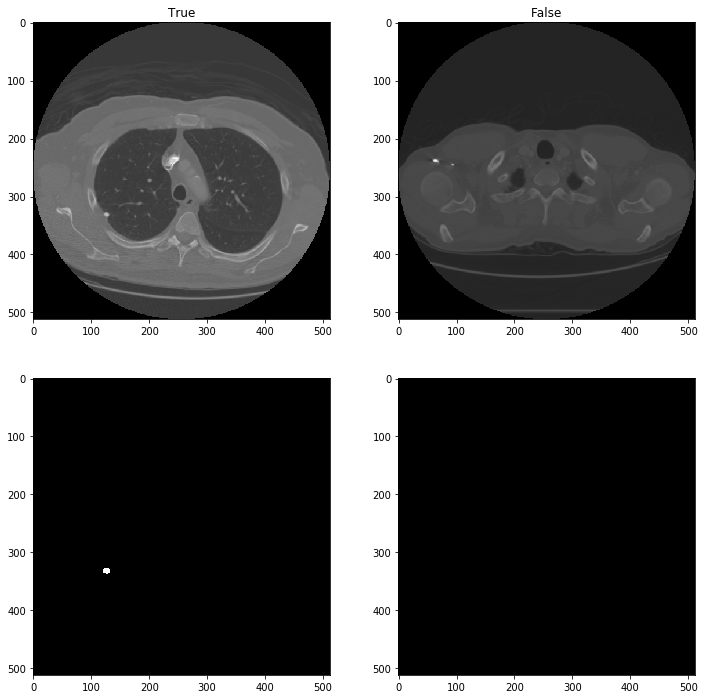

In [18]:
# 1.3: visualize

train_idx_1 = np.random.randint(len(os.listdir('data/extracted/image')))
train_idx_2 = np.random.randint(len(os.listdir('data/extracted/image')))

train_img_1 = imread(f'data/extracted/image/{train_idx_1}.tif') 
train_img_2 = imread(f'data/extracted/image/{train_idx_2}.tif') 
train_mask_1 = imread(f'data/extracted/mask/{train_idx_1}.tif') 
train_mask_2 = imread(f'data/extracted/mask/{train_idx_2}.tif') 
train_label_1 = pickle.load(open(f"data/extracted/label/{train_idx_1}.pkl", "rb" ))
train_label_2 = pickle.load(open(f"data/extracted/label/{train_idx_2}.pkl", "rb" ))

print(train_idx_1)
print(train_idx_2)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0][0].imshow(np.array(train_img_1), cmap='gray')
axs[0][1].imshow(np.array(train_img_2), cmap='gray')
axs[1][0].imshow(np.array(train_mask_1), cmap='gray')
axs[1][1].imshow(np.array(train_mask_2), cmap='gray')
axs[0][0].set_title(train_label_1)
axs[0][1].set_title(train_label_2)
plt.show()

In [19]:
# 2.1: clear out old data
shutil.rmtree('data/processed')

In [20]:
# 2.2 process
preprocess('data/extracted', 'data/processed')

Processing...2390/2390
Complete.


857
1284


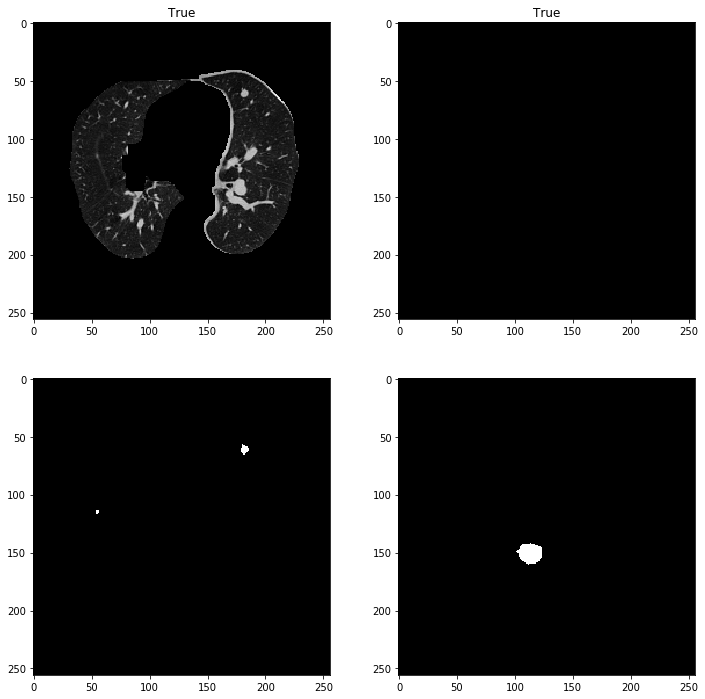

In [21]:
# 2.3: visualize

train_idx_1 = np.random.randint(len(os.listdir('data/processed/image')))
train_idx_2 = np.random.randint(len(os.listdir('data/processed/image')))

train_img_1 = imread(f'data/processed/image/{train_idx_1}.tif') 
train_img_2 = imread(f'data/processed/image/{train_idx_2}.tif') 
train_mask_1 = imread(f'data/processed/mask/{train_idx_1}.tif') 
train_mask_2 = imread(f'data/processed/mask/{train_idx_2}.tif') 
train_label_1 = pickle.load(open(f"data/processed/label/{train_idx_1}.pkl", "rb" ))
train_label_2 = pickle.load(open(f"data/processed/label/{train_idx_2}.pkl", "rb" ))

print(train_idx_1)
print(train_idx_2)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0][0].imshow(np.array(train_img_1), cmap='gray')
axs[0][1].imshow(np.array(train_img_2), cmap='gray')
axs[1][0].imshow(np.array(train_mask_1), cmap='gray')
axs[1][1].imshow(np.array(train_mask_2), cmap='gray')
axs[0][0].set_title(train_label_1)
axs[0][1].set_title(train_label_2)
plt.show()

Number of bad images: 121
1114.tif


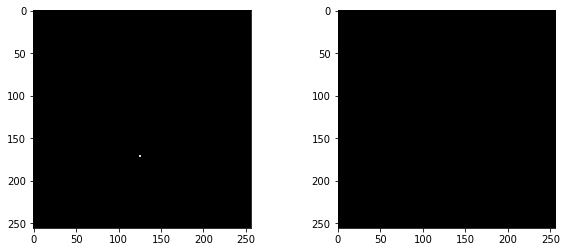

In [22]:
bad_ims = []
for idx in os.listdir('data/processed/image'):
    im = imread(f'data/processed/image/{idx}') 
    # remove if contrast issue after preprocessing
    if len(np.unique(np.clip(im, 0, 100))) < 5:
        bad_ims.append(idx)
    # remove if < 50% of mask in image (got past manual fixes)
    else:
        mask = imread(f'data/processed/mask/{idx}') 
        mask_pixels = im.flatten()[np.argwhere(mask.flatten()>0)]
        if np.count_nonzero(mask_pixels) < (5/10)*mask_pixels.size:
            bad_ims.append(idx)

print(f"Number of bad images: {len(bad_ims)}")

# visualize bad images
bad_idx = bad_ims[np.random.randint(len(bad_ims))]
bad_img = imread(f'data/processed/image/{bad_idx}') 
bad_mask = imread(f'data/processed/mask/{bad_idx}') 

print(bad_idx)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(np.array(bad_img), cmap='bone')
axs[1].imshow(np.array(bad_mask), cmap='bone')
plt.show()

In [25]:
for bad_im in bad_ims:
    os.remove(f'data/processed/image/{bad_im}')
    os.remove(f'data/processed/mask/{bad_im}')

# Split into test and train

In [2]:
# Clear out old data
shutil.rmtree('data/train')
shutil.rmtree('data/test')

In [3]:
test_train_split('data/processed', 'data/train', 'data/test')

# Inspect prepared data

### Training data

1253
940


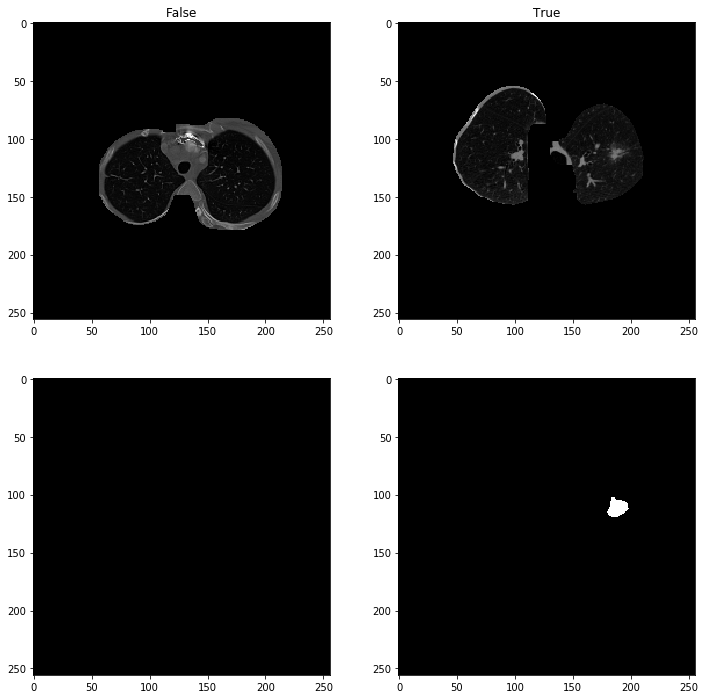

In [4]:
train_idx_1 = np.random.randint(len(os.listdir('data/train/image')))
train_idx_2 = np.random.randint(len(os.listdir('data/train/image')))

train_img_1 = imread(f'data/train/image/{train_idx_1}.tif') 
train_img_2 = imread(f'data/train/image/{train_idx_2}.tif') 
train_mask_1 = imread(f'data/train/mask/{train_idx_1}.tif') 
train_mask_2 = imread(f'data/train/mask/{train_idx_2}.tif') 
train_label_1 = pickle.load(open(f"data/train/label/{train_idx_1}.pkl", "rb" ))
train_label_2 = pickle.load(open(f"data/train/label/{train_idx_2}.pkl", "rb" ))

print(train_idx_1)
print(train_idx_2)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0][0].imshow(np.array(train_img_1), cmap='gray')
axs[0][1].imshow(np.array(train_img_2), cmap='gray')
axs[1][0].imshow(np.array(train_mask_1), cmap='gray')
axs[1][1].imshow(np.array(train_mask_2), cmap='gray')
axs[0][0].set_title(train_label_1)
axs[0][1].set_title(train_label_2)
plt.show()


### Test data

358
150


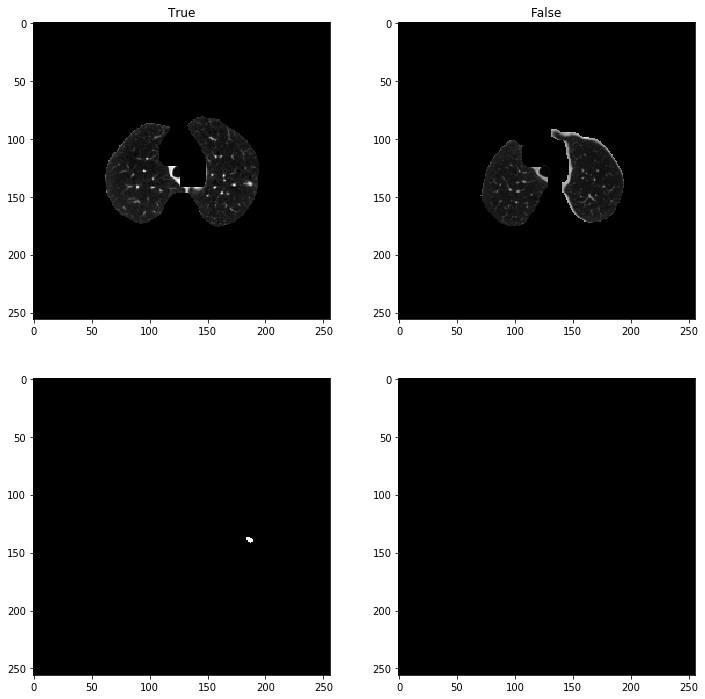

In [6]:
test_idx_1 = np.random.randint(len(os.listdir('data/test/image')))
test_idx_2 = np.random.randint(len(os.listdir('data/test/image')))

test_img_1 = imread(f'data/test/image/{test_idx_1}.tif') 
test_img_2 = imread(f'data/test/image/{test_idx_2}.tif') 
test_mask_1 = imread(f'data/test/mask/{test_idx_1}.tif') 
test_mask_2 = imread(f'data/test/mask/{test_idx_2}.tif') 
test_label_1 = pickle.load(open(f"data/test/label/{test_idx_1}.pkl", "rb" ))
test_label_2 = pickle.load(open(f"data/test/label/{test_idx_2}.pkl", "rb" ))

print(test_idx_1)
print(test_idx_2)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0][0].imshow(np.array(test_img_1), cmap='gray')
axs[0][1].imshow(np.array(test_img_2), cmap='gray')
axs[1][0].imshow(np.array(test_mask_1), cmap='gray')
axs[1][1].imshow(np.array(test_mask_2), cmap='gray')

axs[0][0].set_title(test_label_1)
axs[0][1].set_title(test_label_2)
plt.show()

# Format for genki

In [7]:
ntrain = len(os.listdir('data/train/image/'))
ntest = len(os.listdir('data/test/image/'))

train_idxs, val_idxs = train_test_split(range(ntrain), test_size=.1)
test_idxs = range(ntest)

train_dataset = np.array([imread(f"data/train/image/{i}.tif") for i in train_idxs])
train_masks = np.array([imread(f"data/train/mask/{i}.tif") for i in train_idxs])
train_labels = np.array([pickle.load(open(f"data/train/label/{i}.pkl", "rb" )) for i in train_idxs])

val_dataset = np.array([imread(f"data/train/image/{i}.tif") for i in val_idxs])
val_masks = np.array([imread(f"data/train/mask/{i}.tif") for i in val_idxs])
val_labels = np.array([pickle.load(open(f"data/train/label/{i}.pkl", "rb" )) for i in val_idxs])

test_dataset = np.array([imread(f"data/test/image/{i}.tif") for i in test_idxs])
test_masks = np.array([imread(f"data/test/mask/{i}.tif") for i in test_idxs])
test_labels = np.array([pickle.load(open(f"data/test/label/{i}.pkl", "rb" )) for i in test_idxs])

In [8]:
print(train_dataset.shape, train_labels.shape)
print(val_dataset.shape, val_labels.shape)
print(test_dataset.shape, test_labels.shape)

(1633, 256, 256) (1633,)
(182, 256, 256) (182,)
(454, 256, 256) (454,)


In [9]:
data = {
    'train_dataset': train_dataset,
    'train_masks': train_masks,
    'train_labels': train_labels,
    'valid_dataset': val_dataset,
    'val_masks': val_masks,
    'valid_labels': val_labels,
    'test_dataset': test_dataset,
    'test_masks': test_masks,
    'test_labels': test_labels
}

In [11]:
pickle.dump(data, open('data/genki_data.pkl', 'wb'))